In [1]:
import argparse
import torch
import torch.optim as optim
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import yprov4ml

/Users/cristianmurtas/miniconda3/envs/thesis/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
class Net(nn.Module):
    def __init__(self, model_size, dropout):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        def get_layer_sizes(model_size): 
            if model_size == "small": 
                return 64, 32
            elif model_size == "medium": 
                return 512, 256
            else: 
                return 1024, 256

        l1, l2 = get_layer_sizes(model_size)

        self.fc1 = nn.Linear(12544, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(lr, epochs, batch_size, dropout, model_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    model = Net(model_size, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    scheduler = None

    model.train()

    losses = []
    for _ in range(epochs): 
        for data in tqdm(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()


    yprov4ml.log_carbon_metrics(yprov4ml.Context.TRAINING, step=0)

    return model

def validate(model, batch_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total} %')
    return correct / total

In [4]:
def objective_function(params):
    lr = params["LR"]
    epochs = params["EPOCHS"]
    batch_size = params["BATCH_SIZE"]
    dropout = 0.25
    model_size = "small"

    yprov4ml.start_run(
        prov_user_namespace="www.example.org",
        experiment_name=f"{lr}_{epochs}_{batch_size}_{dropout}_{model_size}", 
        provenance_save_dir="prov",
        save_after_n_logs=100,
        collect_all_processes=False, 
        disable_codecarbon=False, 
        metrics_file_type=yprov4ml.MetricsType.NETCDF,
    )

    yprov4ml.log_param("LR", lr, yprov4ml.Context.TRAINING)
    yprov4ml.log_param("EPOCHS", epochs, yprov4ml.Context.TRAINING)
    yprov4ml.log_param("BATCH_SIZE", batch_size, yprov4ml.Context.TRAINING)
    yprov4ml.log_param("DROPOUT", dropout, yprov4ml.Context.TRAINING)
    yprov4ml.log_param("MODEL_SIZE", model_size, yprov4ml.Context.TRAINING)

    model = train(lr, epochs, batch_size, dropout, model_size)
    accuracy = validate(model, batch_size)

    yprov4ml.log_param("accuracy", accuracy, yprov4ml.Context.TESTING)

    yprov4ml.end_run(
        create_graph=False,
        create_svg=False,
        crate_ro_crate=False
    )

In [5]:
from library import Experiment, SearchSpace, FloatParameter, IntParameter, OptimizationParameters, OptimizerConfig

/Users/cristianmurtas/miniconda3/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
lr = FloatParameter("LR", 0.0001, 0.001)
batch_size = IntParameter("BATCH_SIZE", 16, 32)
epochs = IntParameter("EPOCHS", 5, 10)
search_space = SearchSpace(parameters=[lr, batch_size, epochs])

opt_params = OptimizationParameters(
    input=search_space,
    output=["accuracy", "emissions"],
    directions=["maximize", "minimize"]
)

optimizer_config = OptimizerConfig(
    200, 10, "ucb", 1.0
)

In [7]:
exp = Experiment(
    optimization_parameters=opt_params,
    optimizer_config=optimizer_config,
    path_to_prov="./prov",
    n_iter=2
)

# exp.optimize(objective_function)

In [8]:
inp, out = exp._extract_provenance()
exp.run_clustering(inp, "kmeans")

,LR,BATCH_SIZE,EPOCHS,cluster
0,0.001018,32.0,6.0,0
1,0.000706,32.0,5.0,0
2,0.001018,26.0,5.0,2
3,0.001000,32.0,5.0,0
4,0.000100,16.0,10.0,1


In [9]:
import numpy as np

X = np.array(inp)
y = np.array(out)
y = y[:, 0]
print(y)



[0.6777 0.6622 0.6668 0.6785 0.596 ]


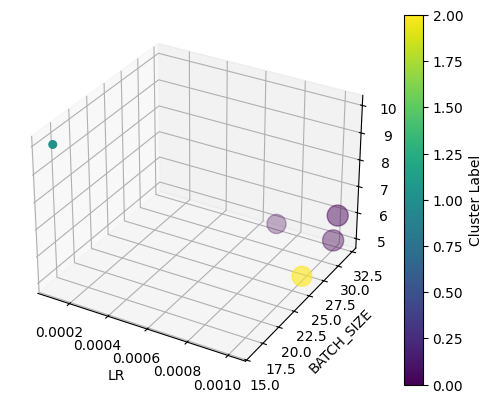

In [10]:
# Plot the result of the clustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
labels = [0, 0, 2, 0, 1]
sizes = 30 + 200 * (y - y.min()) / (y.max() - y.min())

sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, marker='o', s=sizes)
ax.set_xlabel('LR')
ax.set_ylabel('BATCH_SIZE')
ax.set_zlabel('EPOCHS')
plt.colorbar(sc, label='Cluster Label')
plt.show()